In [1]:
############################
### import modules

import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
from scipy import interpolate
import os

###########################

#np.set_printoptions(suppress=True)
os.chdir("../data")  # moves working directory to data folder

In [2]:
############################
### user inputs 

SSMfluxB8 = 5.46e6 #/ cm^2 s  SSM variant: B16-GS98, uncer = 12%
# add SNO B8 flux measurement

inEres = 0.15 # assumed percentage energy resolution at 1 MeV
cserr = 0.1 # percentage cross section error

Smd12 = 5.13e-5 # global solar mass-squared diff
Rmd12 = 7.42e-5 # reactor " "

### systematics
flux_perc = 0.2/5.25*100  #% error on flux (SNO)
cross_perc = 10 #% error in crosssec
spect_perc= 4  #% error in spectrum

#############################

numflux = SSMfluxB8  

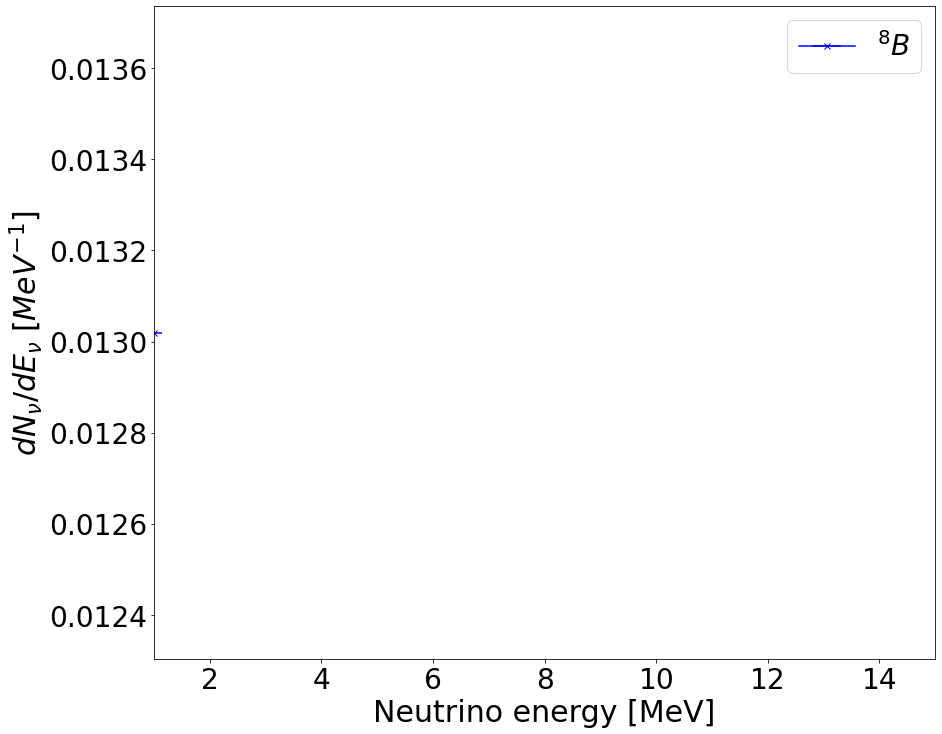

Energy: array([1])
Flux spectrum: array([0.0130196])
Peak energy: [1]
Normalisation: 0.0039058799999999996
Data points: [1]
Bin widths: [0.3]


In [3]:
### imports energy spectrum shape

EvB8 = np.array([])
EvdataB8 = np.array([])
EvdataB8_up = np.array([])
EvdataB8_down = np.array([])
with open('bahcallB8spectrum.csv', 'r') as file: # should add commas to this file
    reader = csv.reader(file)
    for row in reader:
        temp = row[0].split()
        EvB8 = np.append(EvB8, float(temp[0])) # energy values
        EvdataB8 = np.append(EvdataB8, float(temp[1])) # normalisation units
        EvdataB8_up = np.append(EvdataB8_up, float(temp[2]))
        EvdataB8_down = np.append(EvdataB8_down, float(temp[3]))
        
### plot energy spectrum 

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

poptB8, pcovB8 = curve_fit(gaus, EvB8, EvdataB8)

###############################

### variable bin widths based on energy resolution

x = 1 # corresponds to 1 MeV
sigmawidth = 1 # corresponds to a bin width of 1 sigma, controls bin purity

points = np.array([x])
uncer = np.array([inEres*sigmawidth*x])
edges = np.array([x - inEres*sigmawidth*x, x + inEres*sigmawidth*x])


#while x < 18:
#    Eres = inEres/x**0.5 # adds energy dependence
#    xtemp = x*((1+sigmawidth*Eres)/(1-sigmawidth*Eres)) # relation to the next data point
#    uncertemp = Eres*sigmawidth*xtemp
    
#    uncer = np.append(uncer, uncertemp)
#    points = np.append(points, xtemp)
#   edges = np.append(edges, xtemp+ Eres*sigmawidth*xtemp)
    
#    x = xtemp

xdata = np.arange(0, 18, 18)


xdata = points
bwidth = 2*uncer

###############################

tckB8 = interpolate.splrep(EvB8, EvdataB8)
yB8 = interpolate.splev(xdata, tckB8, der=0)

tckB8_up = interpolate.splrep(EvB8, EvdataB8_up)
yB8_up = interpolate.splev(xdata, tckB8_up, der=0)

tckB8_down = interpolate.splrep(EvB8, EvdataB8_down)
yB8_down = interpolate.splev(xdata, tckB8_down, der=0)

yB8[yB8 < 0] = 0 # removes negative values
yB8_up[yB8_up < 0] = 0
yB8_down[yB8_down < 0] = 0
fluxspec = yB8 

plt.figure(figsize=(14,12))

plt.errorbar(xdata, yB8, xerr=uncer, marker="x", color="blue", label=r'${}^{8}B$') # add yerrs from csv file

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel(r'$d N_{\nu}/d E_{\nu}$ [$MeV^{-1}$]',fontsize=30)
plt.xticks(fontsize=28)

plt.yticks(fontsize=28)
#plt.yscale('log')

plt.legend(fontsize=28)
plt.xlim(1,15)

#plt.savefig('../figures/B8spectrum.png', bbox_inches='tight')

plt.show()

print('Energy:', repr(xdata[0:len(fluxspec)]))
print('Flux spectrum:', repr(fluxspec))
print('Peak energy:', xdata[fluxspec == np.max(fluxspec)])
print('Normalisation:', np.sum(yB8*bwidth))
print('Data points:', xdata)
print('Bin widths:', bwidth)

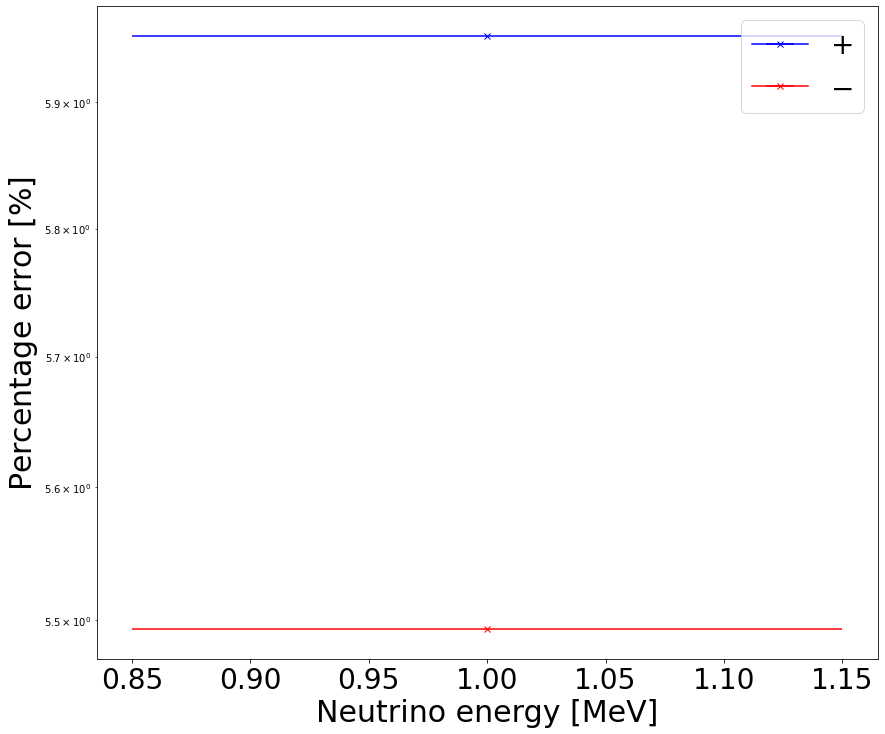

[0.0123044]


In [4]:
plt.figure(figsize=(14,12))

plt.errorbar(xdata, np.sqrt((yB8_up - yB8)**2)*100/yB8, xerr=uncer, marker="x", color="blue", label=r'$+$') # add yerrs from csv file
plt.errorbar(xdata, np.sqrt((yB8 - yB8_down)**2)*100/yB8, xerr=uncer, marker="x", color="red", label=r'$-$') # add yerrs from csv file

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel(r'Percentage error [$\%$]',fontsize=30)
plt.xticks(fontsize=28)

plt.yticks(fontsize=28)
plt.yscale('log')

plt.legend(fontsize=28)
#plt.xlim(1,15)

plt.show()

print(yB8_down)

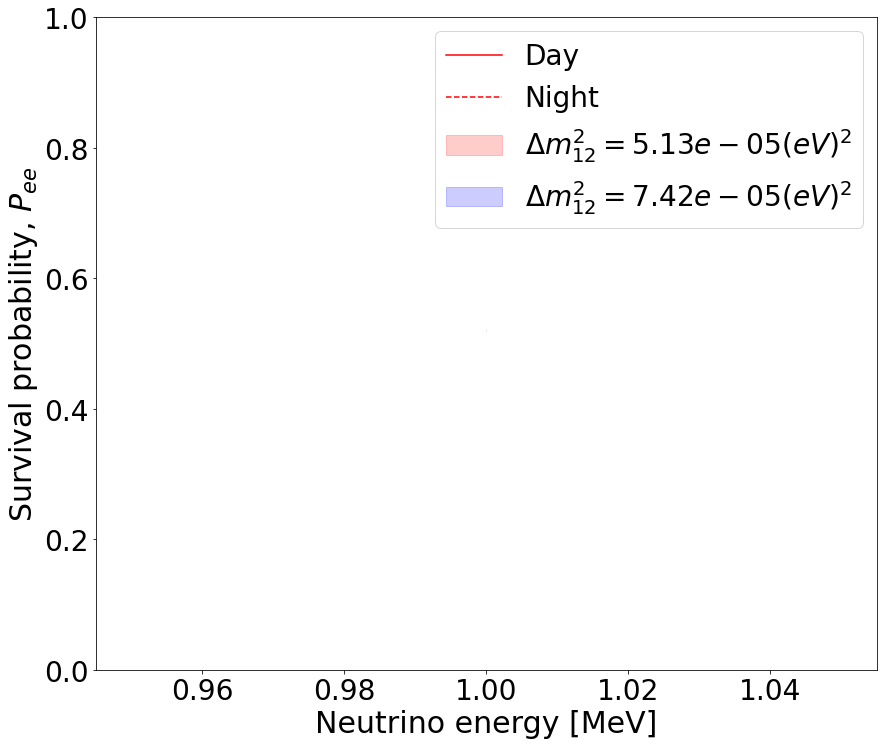

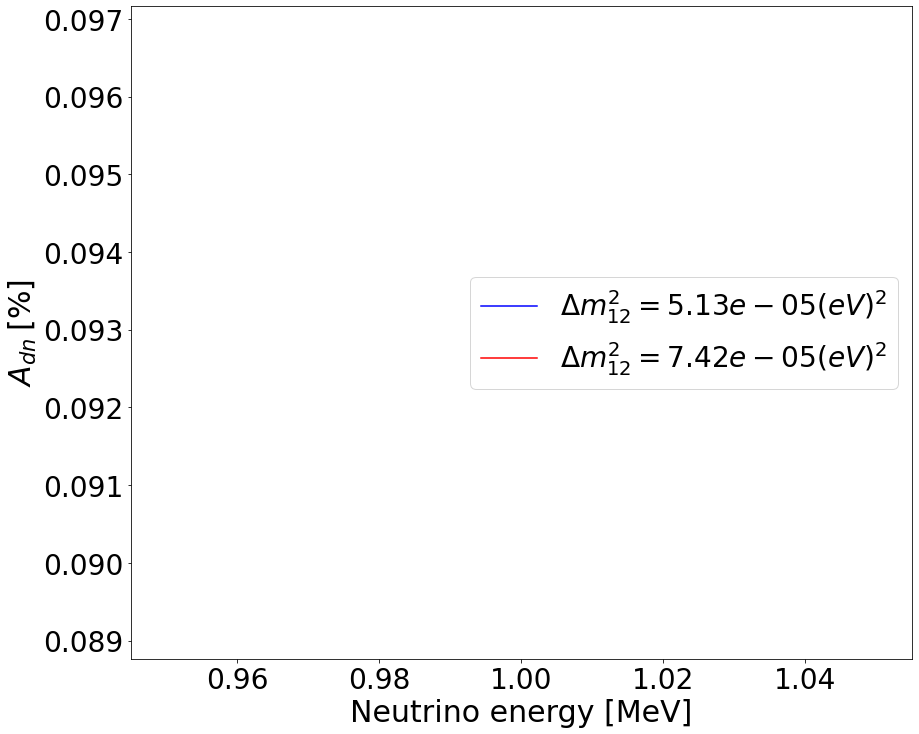

Asymmetry at peak energy: (array([0.52035305]), array([0.5198497]), array([0.00096779]))


In [5]:
def asym(E, md12): # input energy peak and mass-squared diff 21
    
    E = E*1e6 # energy peak of sensitivity curve, assuming asymmetric distribution
    degrad = math.pi/180 # deg.s to rad.s conversion factor
    Gf =  8.958e-44  #eV m3, Fermi constant
    
    ######################################
    # solar input parameters
    
    cMSW = 1 # divergence from msw theory
    peS = 92.5e3/1.673e-27 # m-3, e density of Sun at B8 production point 
    peE = 2.8e3/1.673e-27 # m-3, average e density of Earth 
    # add eccentricity (https://arxiv.org/abs/1506.08158)

    ######################################
    # oscillation parameters:

    #md12 = 7.42e-5 #eV^2, mass-square diff. 
    md13 = 2.515e-3 #eV^2
    
    a12 = 33.4*degrad   # rad, mixing angle
    a13 = 8.57*degrad
    
    s13 = math.sin(a13)
    c13 = math.cos(a13)
    
    s12 = math.sin(a12)
    c12 = math.cos(a12)
    
    s2a12 = math.sin(2*a12)
    c2a12 = math.cos(2*a12)
    
    ######################################
    
    lrS = ((2*2**0.5)*Gf*cMSW*peS*E*(c13**2))/md12 # ratio of oscillation length and refraction length in Sun
    lrE = ((2*2**0.5)*Gf*cMSW*peE*E*(c13**2))/md12 # " " in Earth
    
    c2a12S = (c2a12 - lrS)/(1 - 2*lrS*c2a12 + lrS**2)**0.5 # mixing angle in Sun matter
    c2a12E = (c2a12 - lrE)/(1 - 2*lrE*c2a12 + lrE**2)**0.5 # " " in Earth
    
    s2a12E = np.sin(np.arccos(c2a12E))
    
    freg = 0.5*(c13**2)*lrE*(s2a12E**2) # regenerative factor
    
    pd = (c13**4)*(0.5 + 0.5*c2a12S*c2a12) + s13**4
    pn = pd - c2a12S*(c13**2)*freg
    
    asym = (2*c2a12S*(c13**2)*freg)/(2*pd - c2a12S*(c13**2)*freg)

    return pd, pn, asym

plt.figure(figsize=(14,12))

Spd, Spn, Sasym = asym(xdata, Smd12) # solar day/night surv prob.
Rpd, Rpn, Rasym = asym(xdata, Rmd12) # reactor " "

plt.plot(xdata, Spd, color="red", label=r'Day')
plt.plot(xdata, Spn, color="red", linestyle='dashed', label=r'Night')
plt.fill_between(xdata, Spd, Spn, color='red', alpha=0.2, label=r'$\Delta m_{12}^2 =' + repr(Smd12) + '(eV)^2$')

plt.plot(xdata, Rpd, color="blue")
plt.plot(xdata, Rpn, color="blue", linestyle='dashed')
plt.fill_between(xdata, Rpd, Rpn, color='blue', alpha=0.2, label=r'$\Delta m_{12}^2 =' + repr(Rmd12) + '(eV)^2$')

#plt.xscale('log')
#plt.yscale('log')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'Survival probability, $P_{ee}$',fontsize=30)
plt.yticks(fontsize=28)
plt.ylim(0,1)

plt.legend(fontsize=28)
#plt.savefig('../figures/B8survprob.png', bbox_inches='tight')

plt.show()

##########################################

plt.figure(figsize=(14,12))

plt.plot(xdata, Sasym*100, color="blue", label=r'$\Delta m_{12}^2 =' + repr(Smd12) + '(eV)^2$')
plt.plot(xdata, Rasym*100, color="red", label=r'$\Delta m_{12}^2 =' + repr(Rmd12) + '(eV)^2$')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'$A_{dn~} [\%]$',fontsize=30)
plt.yticks(fontsize=28)

plt.legend(fontsize=28)
#plt.savefig('../figures/B8asymE.png', bbox_inches='tight')

plt.show()

print('Asymmetry at peak energy:', asym(xdata[fluxspec == np.max(fluxspec)], Rmd12))

In [6]:
def optim_bins(mult_arry):
    # optimises bin widths based on Freedman rule of thumb, takes multidimensional array
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    # returns weights of normalised histogram
    
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event) #fraction = expected events / num of events generated
        weights.append(weight)
        i += 1
    
    return weights

def root_input(filename):
    # takes marsum configured MARLEY input file 
    
    rTree = uproot.open(filename)
    
    rTree_event = rTree['mst']
    Ex = np.array(rTree_event['Ex'])
    Ev = np.array(rTree_event['Ev'])
    KEl = np.array(rTree_event['KEl'])
    pdgp = np.array(rTree_event['pdgp'])
    Ep = np.array(rTree_event['Ep'])
    xsec = np.array(rTree_event['xsec'])
    
    return Ex, Ev, KEl, pdgp, Ep, xsec

filename = '/Users/Clara Escanuela/Downloads/B8_marsum.root'
Ex, Ev, KEl, pdgp, Ep, xsec = root_input(filename)

#####################################

plt.figure(figsize=(14,12))

data = [Ex]
rates = [1]

n, bins, patches = plt.hist(data, weights=hist_weights(rates,data), histtype='step', color='blue', bins=optim_bins(data), alpha=1)

plt.xlabel('Excitation energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Normalisation units',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

#plt.savefig('../figures/excit.png', bbox_inches='tight')

plt.show()

###################################

numevents = 10000
data = np.concatenate([Ep[0:numevents]])

#prompt = np.array([])
selecEv = np.array([])

i = 0
for array in data:
    
    if any(1.6 < x < 1.616 for x in array):
        #prompt = np.append(prompt, KEl[i] + (np.sum(array)-1.614-0.03))
        selecEv = np.append(selecEv, Ev[i])

    i += 1
    
plt.figure(figsize=(14,12))

data = [selecEv, Ev[0:numevents]]
labels = ['Selected events', 'Actual events']

n, bins, patches = plt.hist(data, histtype='step', color=['blue', 'red'], label=labels, bins=optim_bins(data), alpha=1)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Normalisation units',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

#################################

plt.figure(figsize=(14,12))

seleceff = n[0]/n[1]
bins = bins[0:len(seleceff)]

plt.scatter(bins, seleceff, color="blue", marker='x')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Selection efficiency',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

plt.ylim(0,1.1)
#plt.legend(fontsize=28)

plt.show()

mseleceff = np.mean(seleceff[(bins > 8) & (bins < 13)])
print('Mean selection efficiency:', mseleceff)


FileNotFoundError: file not found

    '/Users/Clara Escanuela/Downloads/B8_marsum.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [ ]:
plt.figure(figsize=(14,12))

n, edges = np.histogram(Ev, edges, density=True) # bin edges taken

print('Probabaility of detection:', n)
print('Energy bins:', edges)
print('Flux averaged total cross section:', np.mean(xsec))

crosssec = (n*numflux*np.mean(xsec))/fluxspec # calculate cross section used in MARLEY

plt.errorbar(xdata, crosssec, xerr=uncer, yerr=crosssec*cserr, marker='', color="blue", label=r'MARLEY cross section')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel('$d\sigma/dE$ [$10^{-42} cm^{2}/atom\ MeV^{-1}$]',fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.xlim(1,15)
plt.yscale('log')

#plt.savefig('../figures/crosssec.png', bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(14,12))

plt.errorbar(xdata, crosssec*cserr, xerr=uncer, marker='x', color="blue")

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel('Systematic error [%]',fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.xlim(1,15)
#plt.yscale('log')

#plt.savefig('../figures/crosssec.png', bbox_inches='tight')

plt.show()

In [ ]:
def sigmoid(x, a, b, c):
    return a/(1 + np.exp(-b*x+c))

params = [1.01391104, 0.91687735, 8.06047126]

############################

plt.figure(figsize=(14,12))

plt.plot(xdata, sigmoid(xdata, *params), color='blue', marker='x')

plt.ylabel('Trigger efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.show()

###########################

plt.figure(figsize=(14,12))

deteceff = mseleceff*sigmoid(xdata, *params)

plt.plot(xdata, deteceff, color='blue', marker='x')

plt.ylabel('Detection efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

#plt.savefig('../figures/deteceffic.png', bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(14,12))

#Gaussian function

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def f(x, A, B):
    return A*x + B

def R_errors(R, flux_perc, spect_perc, cross_perc):    
    R_var = R**2*((flux_perc/100)**2+(spect_perc/100)**2+(cross_perc/100)**2)
    return np.sqrt(R_var)

resol = inEres
a = np.sqrt(2*np.pi)*resol

sigma = resol
params_lin = [0.99960798, -1.50237267]
eff = 0.4  #deteceff

nt = 10e31 # number of target atoms in 10kT LAr module
fac = 1e-42 # cross-section factor

intnight_E = np.array([])
intday_E = np.array([])

#totflux = 5.25*10**6  #cm-2s-1, SNO

for i in range(0, len(xdata)):
    
    convener = f(xdata, params_lin[0], params_lin[1])
    convE = f(xdata[i], params_lin[0], params_lin[1])
    
    nightval = eff*nt*fluxspec*crosssec*Spn*gauss_function(convener, a/convE, convE, resol*convE)*fac
    nightval[np.isnan(nightval)] = 0
    intnight_E = np.append(intnight_E, sum(nightval))
    
for i in range(0, len(xdata)):
    
    convener = f(xdata, params_lin[0], params_lin[1])
    convE = f(xdata[i], params_lin[0], params_lin[1])
    
    dayval = eff*nt*fluxspec*crosssec*Spd*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
    dayval[np.isnan(dayval)] = 0
    intday_E = np.append(intday_E, sum(dayval))

plt.errorbar(xdata, intnight_E, xerr=uncer, linestyle='',yerr=R_errors(intnight_E, flux_perc, spect_perc, cross_perc), marker="x", color="blue", label='Night')
plt.errorbar(xdata, intday_E, xerr=uncer, linestyle='',yerr=R_errors(intday_E, flux_perc, spect_perc, cross_perc), marker="x", color="red", label='Day')

plt.fill_between(xdata, (intnight_E)+R_errors(intnight_E, flux_perc, spect_perc, cross_perc), (intnight_E)-R_errors(intnight_E, flux_perc, spect_perc, cross_perc), color='blue', alpha=0.2)
plt.fill_between(xdata, (intday_E)+R_errors(intday_E, flux_perc, spect_perc, cross_perc), (intday_E)-R_errors(intday_E, flux_perc, spect_perc, cross_perc), color='red', alpha=0.2)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)

plt.ylabel('$dR/dE$ [$s^{-1}\ MeV^{-1}$] / $10$kt LAr',fontsize=30)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)

plt.xlim(3,17)

#plt.ylim(0, 1500)
#plt.title("SNOwGLoBES", fontsize=20)

#plt.savefig('../figures/sensitiv.png', bbox_inches='tight')
plt.show()

rateday = np.sum(intday_E*bwidth)
ratenight = np.sum(intnight_E*bwidth)
print(rateday, ratenight)

In [ ]:
def asymerr(night, day, back):
    #print(night, day)
    
    tempasymmetry = 2*(night-day)/(night+day+2*back)
    
    tempuncer = np.sqrt((4*(day+back)/(night+day+back)**2)**2*(day) + (4*(night+back)/(night+day+back)**2)**2*(night) 
                        +(4*(night-day)/(night+day+back)**2)**2*(back))
    
    sumasym = np.sum((tempasymmetry/tempuncer**2)[~np.isnan(tempasymmetry/tempuncer**2)])
    sumuncer = np.sum((1/tempuncer**2)[~np.isinf(1/tempuncer**2)])
    print(sumuncer)
    
    asymoutput = (sumasym/sumuncer)
    uncerstat = np.sqrt(1/sumuncer)
    
    uncersys = 0
    
    unceroutput = np.sqrt((uncerstat/asymoutput)**2 + uncersys**2)
    
    return asymoutput*100, asymoutput*unceroutput*100, tempasymmetry, tempuncer

back = 1e0

years = 5
expo = years*3.14e7*4

print(ratenight*expo)

asymfin, uncerfin, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)

print("Night-day asymmetry:", asymfin, "+/-", uncerfin, "%")
print(rateday*expo/5, ratenight*expo/5)

In [ ]:
### Statictical and systematic errors

def asym_errors(n_day, n_night):
    dA_d = (2)*(1/(n_day+n_night)-(n_day-n_night)/(n_day+n_night)**2)
    dA_n = (2)*(-1/(n_day+n_night)-(n_day-n_night)/(n_day+n_night)**2)
    
    stats_d = np.sqrt(n_day)
    stats_n = np.sqrt(n_night)
    
    
    syst_dinv = np.sum(R_errors(intday_E*expo, flux_perc, spect_perc, cross_perc)**2)
    syst_ninv = np.sum(R_errors(intnight_E*expo, flux_perc, spect_perc, cross_perc)**2)
    
    syst_d = syst_dinv
    syst_n = syst_ninv
    
    print(syst_dinv)
    print(stats_d**2)
    print((dA_d)**2)
    
    var_tot = (dA_d)**2*((stats_d**2)+syst_d) + (dA_n)**2*((stats_n**2)+syst_n)
    return np.sqrt(var_tot)*100

In [ ]:
plt.figure(figsize=(14,12))

asymfin, uncerfin, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)

asymDUNE = [asymfin, np.sqrt(uncerfin**2+asymfin*0.1**2)]

asym_values = np.arange(5, 15, 0.05)

def chisquar(obs, uncer, exp):
    
    chisquar = ((obs - exp)**2)/uncer**2
    
    return chisquar

chiDUNE = chisquar(asymDUNE[0], asymDUNE[1], asym_values)
chimin = np.min(chiDUNE)
plt.plot(asym_values, chiDUNE-chimin, color='red')

plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=4, color='black', linestyle='--')
plt.axhline(y=9, color='black', linestyle='--')

plt.text(5.5, 1.1, r'$68\%$ CL', color='black', fontsize=28)
plt.text(5.5, 4.1, r'$95\%$ CL', color='black', fontsize=28)
plt.text(5.5, 9.1, r'$> 99\%$ CL', color='black', fontsize=28)

plt.xlabel(r'$A_{D/N}$',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'$\Delta \chi^2$',fontsize=30)
plt.yticks(fontsize=28)

plt.xlim(5, 15)
plt.ylim(0, 10)
plt.show()

print(asym_values[chiDUNE-chimin <= 1])
print(asym_values[chiDUNE == chimin])